## tensorflow_nlp.ipynb
## NLP : 자연어 처리
## 1) Classification (분류) - 라벨링이 필요
## 2) Machine Translation (번역)
## 3) Text Generation (문장 생성)
## 4) Voice Assistants (보이스 비서)

==> 이런 자연어처리들을 하기 위해서 필요한 것이 -> sequence prolems!!! (문장을 이루는 단어를 숫자로 표현하는 문제)
==> NLP (Natural Language Processing) : 자연어에서 정보를 추려해는 것인 목적
==> NLU (Natural Language Understanding) : 자연어를 이해하고 행동이 목적

자연어에서 이야기하는 용어
1) Text 
2) Speech 

## 우리가 하려는 과정은
텍스트 -> 이 텍스트를 숫자로 변환 -> 모델 생성 -> 패턴을 찾기 위해 모델을 학습 -> 패턴 이용 (예측)

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [4]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [3]:
unzip_data("nlp_getting_started.zip")

In [5]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head(), train_df.shape, test_df.head(), test_df.shape

(   id keyword location                                               text  \
 0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
 1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
 2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
 3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
 4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
 
    target  
 0       1  
 1       1  
 2       1  
 3       1  
 4       1  ,
 (7613, 5),
    id keyword location                                               text
 0   0     NaN      NaN                 Just happened a terrible car crash
 1   2     NaN      NaN  Heard about #earthquake is different cities, s...
 2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
 3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
 4  11     NaN      NaN      Typhoon Soudelor kills 28 in China 

In [6]:
train_df_shuffled = train_df.sample(frac = 1, random_state=42)
train_df_shuffled.head(), train_df_shuffled.shape

(        id      keyword               location  \
 2644  3796  destruction                    NaN   
 2227  3185       deluge                    NaN   
 5448  7769       police                     UK   
 132    191   aftershock                    NaN   
 6845  9810       trauma  Montgomery County, MD   
 
                                                    text  target  
 2644  So you have a new weapon that can cause un-ima...       1  
 2227  The f$&amp;@ing things I do for #GISHWHES Just...       0  
 5448  DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...       1  
 132   Aftershock back to school kick off was great. ...       0  
 6845  in response to trauma Children of Addicts deve...       0  ,
 (7613, 5))

## 우리가 하려는 것
## 입력 (text 컬럼) -> 머신러닝 알고리즘 -> 출력 (target 컬럼)

In [7]:
train_df.target.value_counts()

# 결과값이 0과 1밖에 없기에 binary classification 문제

0    4342
1    3271
Name: target, dtype: int64

In [8]:
print(f"총 학습할 데이터의 수 : {len(train_df)}")
print(f"총 테스트할 데이터의 수 : {len(test_df)}")
print(f"총 데이터의 수 : {len(train_df) + len(test_df)}")

총 학습할 데이터의 수 : 7613
총 테스트할 데이터의 수 : 3263
총 데이터의 수 : 10876


In [9]:
import random

random_index = random.randint(0, len(train_df) - 5)
for row in train_df_shuffled[ ["text", "target"] ][random_index:random_index + 5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "부정" if target > 0 else "긍정")
    print(f"Text: \n{text}\n")
    print("---\n")

Target: 1 부정
Text: 
ÛÏRichmond Coaches were devastated to hear of the death of their second driver Mr Chance who was sittingÛ_: Jam... http://t.co/sHKiMonMlw

---

Target: 0 긍정
Text: 
im getting a car wow it hasn't sunk in

---

Target: 0 긍정
Text: 
@ViralSpell: 'Couple spend wedding day feeding 4000 Syrian refugees. http://t.Û_ http://t.co/I1VPkQ9yAg see more http://t.co/tY5GAvn7uk

---

Target: 1 부정
Text: 
70th anniversary of Hiroshima atomic bombing marked  http://t.co/1mGvd4x5Oe

---

Target: 1 부정
Text: 
Grace: here are damage levels USA style.. #Taiwan #China #world hurricane/typhoon ratings/categories defined again http://t.co/OdYdT9QPk1

---



In [12]:
type(train_df_shuffled["text"]), train_df_shuffled["text"]

(pandas.core.series.Series,
 2644    So you have a new weapon that can cause un-ima...
 2227    The f$&amp;@ing things I do for #GISHWHES Just...
 5448    DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...
 132     Aftershock back to school kick off was great. ...
 6845    in response to trauma Children of Addicts deve...
                               ...                        
 5226    @Eganator2000 There aren't many Obliteration s...
 5390    just had a panic attack bc I don't have enough...
 860     Omron HEM-712C Automatic Blood Pressure Monito...
 7603    Officials say a quarantine is in place at an A...
 7270    I moved to England five years ago today. What ...
 Name: text, Length: 7613, dtype: object)

In [13]:
type(train_df_shuffled["text"].to_numpy()), train_df_shuffled["text"].to_numpy()

(numpy.ndarray,
 array(['So you have a new weapon that can cause un-imaginable destruction.',
        'The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@',
        'DT @georgegalloway: RT @Galloway4Mayor: \x89ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q',
        ...,
        'Omron HEM-712C Automatic Blood Pressure Monitor STANDARD AND LARGE BP CUFFS http://t.co/gJBAInQWN9 http://t.co/jPhgpL1c5x',
        'Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY',
        'I moved to England five years ago today. What a whirlwind of time it has been! http://t.co/eaSlGeA1B7'],
       dtype=object))

In [10]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size = 0.1,
    random_state= 42
)

In [11]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [12]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## 이제 모든 데이터 준비가 끝났습니다!
## 라벨인 target은 숫자! -> 기계가 아주 잘 인식!!!
## 문제는 text가 문자열! -> 기계가 인식하기 어려움!!!
## 문자열을 숫자로 바꾸어 주는 과정이 필요합니다

## NLP에서는 텍스트를 숫자로 바꾸어주는 2가지 주요 개념이 존재!
## 1) Tokenization : 단어, 문자 등을 바로 숫자로 변환
       1. Word-level tokenization : 모든 기본 단위가 word
       2. Chacracter-level tokenization : A ~ Z => 1 ~ 26, 모든 글자가 단위
       3. Sub-word-level tokenization : word-level tokenization과 character-level tokenization의 중간 / favorite => favor + rite
## 2) Embedding : 자연어를 학습할 수 있는 형태로 표현한 것, 이런 표현은 feature vector의 형태로 제공합니다.
      dance라는 단어가 있을 때 [-0.3412, 0.3424, -0.2343, 0.9934, 0.1112]와 같이 표현됨
      feature vector의 크기는 조정이 가능하다.
      1. 자신만의 embedding을 사용
      2. 사전에 학습된 embedding을 사용

## 각각 어떤 것을 사용해야하는 것은 문제에 따라 다르다!

In [1]:
import tensorflow as tf
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization # Tensorflow 2.6 이전 방식

In [2]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens = None,
    standardize = "lower_and_strip_punctuation",
    split = "whitespace",
    ngrams = None,
    output_mode = "int",
    output_sequence_length = None
)

In [13]:
round(sum(
    [len(i.split()) for i in train_sentences]) / len(train_sentences)
)

15

In [34]:
max_vocab_length = 10000
max_length = 15

text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens = max_vocab_length,
    standardize = "lower_and_strip_punctuation",
    split = "whitespace",
    ngrams = None,
    output_mode = "int",
    output_sequence_length = max_length
)

In [35]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

AttributeError: 'NoneType' object has no attribute 'ndims'

In [36]:
text_vectorizer.adapt(train_sentences)

In [37]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [38]:
sample_sentence = "I love tensorflow"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  8, 110,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [39]:
sample_sentence = "I Can do TensorFlow"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 8, 71, 68,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int64)>

In [40]:
random_sentence = random.choice(train_sentences)
print(f"원래 Text : \n{random_sentence}\n\nVector : ")
text_vectorizer([random_sentence])

원래 Text : 
Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding

Vector : 


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 847,  593, 2662,    9,  209, 2995, 5521,  637,    3,  642,    8,
         199,    4,  593, 2662]], dtype=int64)>

In [44]:
words_in_vocab = text_vectorizer.get_vocabulary()

In [45]:
type(words_in_vocab), len(words_in_vocab)

(list, 10000)

In [48]:
top_5_words = words_in_vocab[:5]  # [UNK] : unknown 를 의미
bottom_5_words = words_in_vocab[-5:]

In [49]:
print(f"vocab에 있는 단어 총 갯수 : {len(words_in_vocab)}")
print(f"자주 사용하는 단어 5개 : {top_5_words}")
print(f"자주 사용하지 않는 단어 5개 : {bottom_5_words}")

vocab에 있는 단어 총 갯수 : 10000
자주 사용하는 단어 5개 : ['', '[UNK]', 'the', 'a', 'in']
자주 사용하지 않는 단어 5개 : ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## 정말 간단하게 tokenization을 했습니다. 문장을 숫자로 이루어진 벡터로 만들었습니다.
## embedding의 특징 : tokennization의 경우 tensorflow = 1, I = 8
##                   이 값들은 우리가 다시 새로운 데이터셋으로 adopt를 하지 않으면
##                   계속 유지
## embedding은 단어들간의 관계 (relation)를 표현하기 때문에, 학습을 하면서 변경이 된다! 즉 개선이 된다.

In [50]:
from tensorflow.keras import layers

In [51]:
embedding = layers.Embedding(
    input_dim = max_vocab_length,
    output_dim = 128, # embedding vector의 크기
    embeddings_initializer = "uniform",
    input_length = max_length
)
embedding

In [57]:
random_sentence = random.choice(train_sentences)
print(f"원래 Text : \n{random_sentence}\n\nEmbedded : ")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

원래 Text : 
I LAVA YOU.

Embedded : 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03842573,  0.01449363, -0.01360431, ..., -0.0302658 ,
          0.02257574, -0.02653332],
        [ 0.01334765, -0.01756917, -0.01153872, ..., -0.0064621 ,
         -0.0351951 , -0.04888349],
        [ 0.04480051, -0.0264637 ,  0.02962433, ..., -0.02560654,
          0.01879858,  0.01700368],
        ...,
        [-0.04715964,  0.03798088,  0.01226502, ...,  0.01601822,
          0.04542531,  0.0255288 ],
        [-0.04715964,  0.03798088,  0.01226502, ...,  0.01601822,
          0.04542531,  0.0255288 ],
        [-0.04715964,  0.03798088,  0.01226502, ...,  0.01601822,
          0.04542531,  0.0255288 ]]], dtype=float32)>

In [59]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.03842573,  0.01449363, -0.01360431, -0.04006778,  0.00339891,
       -0.04589501,  0.01881088, -0.00758136,  0.04664798, -0.013203  ,
       -0.00238113, -0.04470152, -0.01492572,  0.01903288, -0.02764055,
        0.03634011, -0.00748052, -0.03234205, -0.02379128,  0.02365288,
        0.01844326, -0.04424445, -0.00243623, -0.02265985,  0.0157547 ,
       -0.01304866, -0.02187171, -0.03622397,  0.02546528,  0.03338465,
        0.01150749,  0.00638796, -0.00525988, -0.01641666, -0.04038722,
        0.02887448,  0.02615959, -0.03832792,  0.0294642 , -0.0489084 ,
        0.02392549,  0.03432212,  0.00364852, -0.03967185,  0.00497659,
        0.01708763,  0.04872471,  0.02718883, -0.00628611, -0.04688453,
       -0.00987806,  0.04842838,  0.04946474, -0.00306113, -0.0237103 ,
        0.03145838, -0.02748504, -0.00488142, -0.0008931 ,  0.03056872,
        0.04024469,  0.01253624, -0.01311201,  0.02665125,  0.02681747,
       -0.030925

## 이제 우리는 학습할 수 있는 데이터를 준비했습니다.
## 1. Model 0 : Naive Bayes
## 2. Model 1 : Feed-forward neural network (dense model)
## 3. Model 2 : LSTM
## 4. Model 3 : GRU
## 5. Model 4 : Bidirectional-LSTM
## 6. Model 5 : 1D CNN
## 7. Model 6 : Tensorflow Hub pretrained feature extractor 
## 8. Model 7 : 전이학습

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [63]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # tfidf를 사용해서 단어를 숫자로 변경
    ("clf", MultinomialNB()) # 텍스트를 모델링
])

In [64]:
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [66]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Model 0의 accuracy는 {baseline_score * 100:.2f}%")

Model 0의 accuracy는 79.27%


In [67]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [68]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [71]:
def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy" : model_accuracy,
        "precision" : model_precision,
        "recall" : model_recall,
        "f1" : model_f1
    }
    return model_results

In [72]:
baseline_results = calculate_results(y_true = val_labels, y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1 : simple Dense Model

In [73]:
from helper_functions import create_tensorboard_callback

In [74]:
SAVE_DIR = "model_logs"

In [78]:
# Functional API으로 모델을 생성! 이전에는 sequencial 방법을 사용
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string") # 입력이 1차원 문자열
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name = "model_1_dense")

In [79]:
model_1.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
model_1.summary()

In [81]:
model_1_history = model_1.fit(
    train_sentences,
    train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [
        create_tensorboard_callback(
            dir_name = SAVE_DIR,
            experiment_name = "simple_dense_model"
        )
    ]
)

Saving TensorBoard log files to: model_logs/simple_dense_model/20210911-160443
Epoch 1/5
215/215 [==============================] - 6s 22ms/step - loss: 0.6104 - accuracy: 0.6935 - val_loss: 0.5359 - val_accuracy: 0.7441
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4408 - accuracy: 0.8171 - val_loss: 0.4733 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3458 - accuracy: 0.8625 - val_loss: 0.4555 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 4s 21ms/step - loss: 0.2826 - accuracy: 0.8911 - val_loss: 0.4638 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2368 - accuracy: 0.9115 - val_loss: 0.4833 - val_accuracy: 0.7900


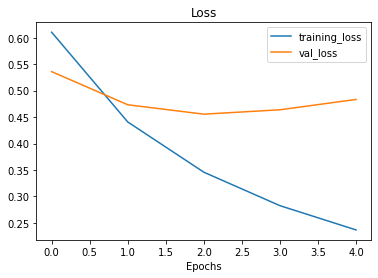

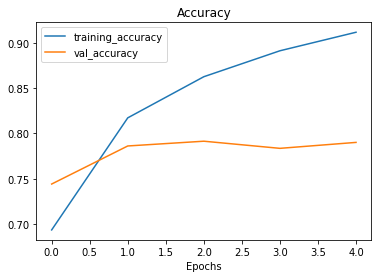

In [82]:
from helper_functions import plot_loss_curves

plot_loss_curves(model_1_history)

In [86]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10], type(model_1_pred_probs), model_1_pred_probs.shape

(array([[0.30788076],
        [0.79422003],
        [0.9977535 ],
        [0.09575728],
        [0.11065897],
        [0.93283117],
        [0.90759754],
        [0.9938569 ],
        [0.96212596],
        [0.22399926]], dtype=float32),
 numpy.ndarray,
 (762, 1))

In [88]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [89]:
model_1_results = calculate_results(y_true = val_labels, y_pred=model_1_preds)
model_1_results

{'accuracy': 79.00262467191601,
 'precision': 0.7975156487081627,
 'recall': 0.7900262467191601,
 'f1': 0.7863113264688066}

In [96]:
import numpy as np

np.array( list(model_1_results.values())) > np.array( list(baseline_results.values()))

array([False, False, False,  True])

In [98]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [99]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_3 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________
